In [58]:
# So get a list of players at the start of a quarter for each time (home 1-5 and away 1-5)
# I think I'll need to loop through each row of the dataframe and modify the list of players for each sub event (home and away)
#     Will also calculate the margin, score, and seconds for each

In [1]:
import requests
import pandas as pd
import numpy as np
import random
import time
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression
pd.set_option('display.max_columns',500)

In [2]:
# play_by_play_url = 'https://stats.nba.com/stats/playbyplayv2/?gameId=0041700404&&startPeriod=0&endPeriod=14' #
# games_url = 'https://stats.nba.com/stats/leaguegamelog?\
# Counter=1000&DateFrom=&DateTo=&Direction=DESC&LeagueID=00\
# &PlayerOrTeam=T&Season=2021-22&SeasonType=Playoffs&Sorter=DATE' #
# players_game_url = 'https://stats.nba.com/stats/boxscoreadvancedv2/?gameId=0041700404&startPeriod=0&endPeriod=14&startRange=7205&endRange=14395&rangeType=2'

In [3]:
# Headers for querying NBA JSON data api
header_data  = {
    'Connection': 'keep-alive',
    'Accept': 'application/json, text/plain, */*',
    'x-nba-stats-token': 'true',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
}

In [4]:
# code for getting starting quarter lineups from here: https://github.com/rd11490/NBA-Play-By-Play-Example
# endpoints
def play_by_play_url(game_id):
    return "https://stats.nba.com/stats/playbyplayv2/?gameId={0}&startPeriod=0&endPeriod=14".format(game_id)

def advanced_boxscore_url(game_id, start, end):
    return "https://stats.nba.com/stats/boxscoreadvancedv2/?gameId={0}&startPeriod=0&endPeriod=14&startRange={1}&endRange={2}&rangeType=2".format(game_id, start, end)

def games_url(season,season_type):
    return 'https://stats.nba.com/stats/leaguegamelog?Counter=1000&DateFrom=&DateTo=&Direction=DESC&LeagueID=00&PlayerOrTeam=T&Season={}&SeasonType={}&Sorter=DATE'.format(season,season_type)

def players_url(season,season_type,historical=1):
    return 'https://stats.nba.com/stats/playerindex?LeagueID=00&season={}&SeasonType={}&Historical={}'.format(season,season_type,historical)

def player_minutes_url(season,season_type):
    return 'https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=Totals&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={}&SeasonSegment=&SeasonType={}&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=&Weight='.format(season,season_type)

def extract_data(url):
    resp = requests.get(url, headers=header_data).json()
#     resp = json.loads(r.data)
    results = resp['resultSets'][0]
    headers = results['headers']
    rows = results['rowSet']
    frame = pd.DataFrame(rows)
    frame.columns = headers
    return frame

def calculate_time_at_period(period):
    if period > 5:
        return (720 * 4 + (period - 5) * (5 * 60)) * 10
    else:
        return (720 * (period - 1)) * 10
    
def split_subs(df, tag):
    subs = df[[tag, 'PERIOD', 'EVENTNUM']]
    subs['SUB'] = tag
    subs.columns = ['PLAYER_ID', 'PERIOD', 'EVENTNUM', 'SUB']
    return subs

def get_all_games(season,season_type):
    games = extract_data(games_url(season,season_type))
    games = games[games['MATCHUP'].str.contains('vs.')][['GAME_ID','MATCHUP']]
    games['HOME']=games['MATCHUP'].str.split(' vs. ').str.get(0)
    games['AWAY']=games['MATCHUP'].str.split(' vs. ').str.get(1)
    return games

def get_player_general(season,season_type):
    player_general = extract_data(players_url(season,season_type))
    player_general = player_general[['PLAYER_FIRST_NAME','PLAYER_LAST_NAME','TEAM_ABBREVIATION',
                                     'PERSON_ID',
                                     'POSITION','HEIGHT','WEIGHT','DRAFT_YEAR','FROM_YEAR','TO_YEAR']]
#     player_general['SEASON'] = season
    player_general.rename({'PERSON_ID':'PLAYER_ID'},axis=1,inplace=True)
    return player_general

def get_player_minutes(season,season_type):
    player_minutes = extract_data(player_minutes_url(season,season_type))
    return player_minutes[['PLAYER_ID','PLAYER_NAME','TEAM_ABBREVIATION','GP','MIN']]


def get_game_data(game_id,games):
    # Get the play-by-play data
    frame = extract_data(play_by_play_url(game_id)).fillna('')
    # Get the substitutions
    substitutionsOnly = frame[frame["EVENTMSGTYPE"] == 8][['PERIOD', 'EVENTNUM', 'PLAYER1_ID', 'PLAYER2_ID']]
    substitutionsOnly.columns = ['PERIOD', 'EVENTNUM', 'OUT', 'IN']

    subs_in = split_subs(substitutionsOnly, 'IN')
    subs_out = split_subs(substitutionsOnly, 'OUT')

    full_subs = pd.concat([subs_out, subs_in], axis=0).reset_index()[['PLAYER_ID', 'PERIOD', 'EVENTNUM', 'SUB']]
    first_event_of_period = full_subs.loc[full_subs.groupby(by=['PERIOD', 'PLAYER_ID'])['EVENTNUM'].idxmin()]
    players_subbed_in_at_each_period = first_event_of_period[first_event_of_period['SUB'] == 'IN'][['PLAYER_ID', 'PERIOD', 'SUB']]

    periods = frame['PERIOD'].drop_duplicates().values.tolist()

    frames = []
    for period in periods:

        low = calculate_time_at_period(period) + 5
        high = calculate_time_at_period(period + 1) - 5
        boxscore = advanced_boxscore_url(game_id, low, high)
        boxscore_players = extract_data(boxscore)[['PLAYER_NAME', 'PLAYER_ID', 'TEAM_ABBREVIATION']]
        boxscore_players['PERIOD'] = period

        players_subbed_in_at_period = players_subbed_in_at_each_period[players_subbed_in_at_each_period['PERIOD'] == period]

        joined_players = pd.merge(boxscore_players, players_subbed_in_at_period, on=['PLAYER_ID', 'PERIOD'], how='left')
        joined_players = joined_players[pd.isnull(joined_players['SUB'])][['PLAYER_NAME', 'PLAYER_ID', 'TEAM_ABBREVIATION', 'PERIOD']]
        frames.append(joined_players)

    out = pd.concat(frames)    
    out = out.groupby(['TEAM_ABBREVIATION','PERIOD'])['PLAYER_ID'].apply(lambda x: ','.join(map(str, x))).reset_index()
    
    # Get home and away game data
    frame['HOME']=games[games['GAME_ID']==game_id]['HOME'].values[0]
    frame['AWAY']=games[games['GAME_ID']==game_id]['AWAY'].values[0]
    frame = frame.merge(out,how='left',left_on=['HOME','PERIOD'],right_on=['TEAM_ABBREVIATION','PERIOD']).drop('TEAM_ABBREVIATION',axis=1)
    frame.rename({'PLAYER_ID':'HOME_PLAYER_IDS'},axis=1,inplace=2)
    frame = frame.merge(out,how='left',left_on=['AWAY','PERIOD'],right_on=['TEAM_ABBREVIATION','PERIOD']).drop('TEAM_ABBREVIATION',axis=1)
    frame.rename({'PLAYER_ID':'AWAY_PLAYER_IDS'},axis=1,inplace=2)
    return frame

def process_play_by_play_data(frame):
    frame['HOME_SUB']=frame['HOMEDESCRIPTION'].str.contains('SUB')
    frame['AWAY_SUB']=frame['VISITORDESCRIPTION'].str.contains('SUB')
    frame['QUARTER_START']=frame['NEUTRALDESCRIPTION'].str.contains('Start')
    frame['PLAYER_CHANGE']=np.where((frame['QUARTER_START']==True)|(frame['AWAY_SUB']==True)|(frame['HOME_SUB']==True),True,False)
    frame['HOME_PLAYER_IDS']=np.where(frame['QUARTER_START']==True,frame['HOME_PLAYER_IDS'],np.nan)
    frame['AWAY_PLAYER_IDS']=np.where(frame['QUARTER_START']==True,frame['AWAY_PLAYER_IDS'],np.nan)
    
    for idx, row in frame.iterrows():
        if idx == 0 or row['QUARTER_START']==True:
            continue
        else:
            frame.at[idx,'AWAY_PLAYER_IDS']=frame.at[idx-1,'AWAY_PLAYER_IDS']
            frame.at[idx,'HOME_PLAYER_IDS']=frame.at[idx-1,'HOME_PLAYER_IDS']
            if row['AWAY_SUB']==True:
                frame.at[idx,'AWAY_PLAYER_IDS']=frame.at[idx,'AWAY_PLAYER_IDS'].replace(str(row['PLAYER1_ID']),str(row['PLAYER2_ID']))
            if row['HOME_SUB']==True:
                frame.at[idx,'HOME_PLAYER_IDS']=frame.at[idx,'HOME_PLAYER_IDS'].replace(str(row['PLAYER1_ID']),str(row['PLAYER2_ID']))
    frame['HOME_PLAYER_IDS'].ffill(inplace=True)
    frame['AWAY_PLAYER_IDS'].ffill(inplace=True)
    
    frame=frame[frame['PLAYER_CHANGE']==False]
    frame=frame[frame['NEUTRALDESCRIPTION']=='']
    frame=frame[(~frame['HOMEDESCRIPTION'].str.contains('Jump Ball'))&(~frame['VISITORDESCRIPTION'].str.contains('Jump Ball'))]
    frame=frame[(~frame['HOMEDESCRIPTION'].str.contains('Timeout'))&(~frame['VISITORDESCRIPTION'].str.contains('Timeout'))]
    
    frame['NEXT_HOME_PLAY']=frame['HOMEDESCRIPTION'].shift(-1)
    frame['NEXT_AWAY_PLAY']=frame['VISITORDESCRIPTION'].shift(-1)
    frame['TIMER']=frame['PCTIMESTRING'].str.split(':').str.get(0).astype(int)+frame['PCTIMESTRING'].str.split(':').str.get(1).astype(int)/60
    frame['SECONDS_PASSED']=np.where(frame['TIMER'].shift(1)>=frame['TIMER'],frame['TIMER'].shift(1)*60-frame['TIMER']*60,(np.ceil(frame['TIMER'])-frame['TIMER'])*60)
    frame['HOME_POSSESSION_FLAG']=np.where((frame['NEXT_HOME_PLAY']=='')&(frame['HOMEDESCRIPTION']!=''),1,0)
    frame['AWAY_POSSESSION_FLAG']=np.where((frame['NEXT_AWAY_PLAY']=='')&(frame['VISITORDESCRIPTION']!=''),1,0)
    
    frame['AWAY_SCORE']=frame['SCORE'].str.split(' - ').str.get(0)
    frame['AWAY_SCORE']=np.where(frame['AWAY_SCORE']=='',np.nan,frame['AWAY_SCORE'])
    frame['AWAY_SCORE'].ffill(inplace=True)
    frame['AWAY_SCORE'].fillna(0,inplace=True)
    frame['HOME_SCORE']=frame['SCORE'].str.split(' - ').str.get(1)
    frame['HOME_SCORE'].ffill(inplace=True)
    frame['HOME_SCORE'].fillna(0,inplace=True)
    frame['HOME_SCORE_DIFFERENCE']=frame['HOME_SCORE'].astype(int)-frame['HOME_SCORE'].astype(int).shift(1)
    frame['AWAY_SCORE_DIFFERENCE']=frame['AWAY_SCORE'].astype(int)-frame['AWAY_SCORE'].astype(int).shift(1)
    frame['HOME_SCORE_DIFFERENCE'].fillna(0,inplace=True)
    frame['AWAY_SCORE_DIFFERENCE'].fillna(0,inplace=True)
    frame['HOME_VS_AWAY']=frame['HOME_SCORE_DIFFERENCE']-frame['AWAY_SCORE_DIFFERENCE']
    return frame

In [5]:
season = '2021-22'
season_type = 'Regular+Season'
games = get_all_games(season,season_type)
games

,GAME_ID,MATCHUP,HOME,AWAY
1,0022101224,MIN vs. CHI,MIN,CHI
2,0022101228,PHI vs. DET,PHI,DET
5,0022101223,MEM vs. BOS,MEM,BOS
7,0022101220,DEN vs. LAL,DEN,LAL
8,0022101227,ORL vs. MIA,ORL,MIA
...,...,...,...,...
2450,0022100006,TOR vs. WAS,TOR,WAS
2452,0022100004,DET vs. CHI,DET,CHI
2454,0022100003,CHA vs. IND,CHA,IND
2457,0022100001,MIL vs. BKN,MIL,BKN


In [6]:
players = get_player_general(season,season_type)
players

,PLAYER_FIRST_NAME,PLAYER_LAST_NAME,TEAM_ABBREVIATION,PLAYER_ID,POSITION,HEIGHT,WEIGHT,DRAFT_YEAR,FROM_YEAR,TO_YEAR
0,Alaa,Abdelnaby,POR,76001,F,6-10,240,1990.0,1990,1994
1,Zaid,Abdul-Aziz,HOU,76002,C,6-9,235,1968.0,1968,1977
2,Kareem,Abdul-Jabbar,LAL,76003,C,7-2,225,1969.0,1969,1988
3,Mahmoud,Abdul-Rauf,DEN,51,G,6-1,162,1990.0,1990,2000
4,Tariq,Abdul-Wahad,SAC,1505,F-G,6-6,235,1997.0,1997,2003
...,...,...,...,...,...,...,...,...,...,...
4726,Ante,Zizic,CLE,1627790,C,6-10,266,2016.0,2017,2019
4727,Jim,Zoet,DET,78647,C,7-1,240,NaN,1982,1982
4728,Bill,Zopf,MIL,78648,G,6-1,170,1970.0,1970,1970
4729,Ivica,Zubac,LAC,1627826,C,7-0,240,2016.0,2016,2021


In [7]:
player_minutes = get_player_minutes(season,season_type)
player_minutes

,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GP,MIN
0,203932,Aaron Gordon,DEN,75,2375.418333
1,1630565,Aaron Henry,PHI,6,16.983333
2,1628988,Aaron Holiday,PHX,63,1020.750000
3,1630174,Aaron Nesmith,BOS,52,573.878333
4,1630598,Aaron Wiggins,OKC,50,1208.750000
...,...,...,...,...,...
600,203897,Zach LaVine,CHI,67,2328.078333
601,1630285,Zavier Simpson,OKC,4,174.083333
602,1630192,Zeke Nnaji,DEN,41,697.608333
603,1630533,Ziaire Williams,MEM,62,1346.466667


In [8]:
player_minutes_low = player_minutes[(player_minutes['GP']<10)|(player_minutes['MIN']<200)]
player_minutes_low

,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GP,MIN
1,1630565,Aaron Henry,PHI,6,16.983333
5,1627846,Abdel Nader,PHX,14,145.238333
6,1630278,Ade Murkey,SAC,1,1.466667
8,1629958,Ahmad Caver,IND,1,0.843333
11,1630758,Aleem Ford,ORL,5,73.530000
...,...,...,...,...,...
594,1629875,Xavier Moon,LAC,10,137.368333
595,1630270,Xavier Sneed,UTA,9,38.716667
598,1630582,Yves Pons,MEM,12,70.975000
601,1630285,Zavier Simpson,OKC,4,174.083333


In [69]:
now_time = str(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())).replace(' ','-').replace(':','-')

In [70]:
problem_games = []
completed_games = []
i = 0
for game in games['GAME_ID'].values:
    if i == 0:
        results = get_game_data(game_id=game,games=games)
        results.to_csv('play_by_play_run'+now_time+'.csv')
        completed_games.append(game)
    else:
        try:
            results = get_game_data(game_id=game,games=games)
            completed_games.append(game)
            results.to_csv('play_by_play_run'+now_time+'.csv', mode='a', header=False)
        except Exception as e:
            print('Problem with run ' + str(i+1) + ', game id ' + str(game))
            print(e)
            problem_games.append(game)
        if (i+1)%10 == 0:
            print('Run ' + str(i+1) + ' completed. ' + str(len(games['GAME_ID'])-i+1) + ' to go.')
    i+=1
    # Wait time to not get banned from API
    time.sleep(random.randint(5,10))
print('Done with the errors in the problem_games list.')

Problem with run 7, game id 0022101216
('Connection aborted.', OSError(0, 'Error'))
Problem with run 10, game id 0022101218
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Run 10 completed. 1222 to go.
Problem with run 12, game id 0022101230
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Problem with run 16, game id 0022101212
('Connection aborted.', OSError(0, 'Error'))
Problem with run 17, game id 0022101215
('Connection aborted.', OSError(0, 'Error'))
Problem with run 19, game id 0022101214
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Run 20 completed. 1212 to go.
Run 30 completed. 1202 to go.
Problem with run 31, game id 0022101201
('Connection aborted.', OSError(0, 'Error'))
Problem with run 36, game id 0022101195
('Connection aborted.', OSError(0, 'Error'))
Problem with run 39, game id 0022101192
('Connection aborted.', OSError(0, 'Error'))
Pr

Problem with run 305, game id 0022100930
('Connection aborted.', OSError(0, 'Error'))
Problem with run 309, game id 0022100926
('Connection aborted.', OSError(0, 'Error'))
Run 310 completed. 922 to go.
Problem with run 312, game id 0022100925
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Problem with run 317, game id 0022100914
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Run 320 completed. 912 to go.
Problem with run 328, game id 0022100908
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Run 330 completed. 902 to go.
Problem with run 331, game id 0022100905
('Connection aborted.', OSError(0, 'Error'))
Problem with run 338, game id 0022100899
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Problem with run 340, game id 0022100896
('Connection aborted.', RemoteDisconnected('Remote end closed connection wi

Run 620 completed. 612 to go.
Problem with run 623, game id 0022100616
('Connection aborted.', OSError(0, 'Error'))
Run 630 completed. 602 to go.
Problem with run 634, game id 0022100607
('Connection aborted.', OSError(0, 'Error'))
Problem with run 640, game id 0022100597
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Run 640 completed. 592 to go.
Problem with run 650, game id 0022100594
('Connection aborted.', OSError(0, 'Error'))
Run 650 completed. 582 to go.
Problem with run 656, game id 0022100586
('Connection aborted.', OSError(0, 'Error'))
Problem with run 658, game id 0022100585
('Connection aborted.', OSError(0, 'Error'))
Problem with run 659, game id 0022100583
('Connection aborted.', OSError(0, 'Error'))
Run 660 completed. 572 to go.
Problem with run 661, game id 0022100581
('Connection aborted.', OSError(0, 'Error'))
Problem with run 662, game id 0022100579
('Connection aborted.', RemoteDisconnected('Remote end closed connection 

Problem with run 930, game id 0022100302
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Run 930 completed. 302 to go.
Problem with run 940, game id 0022100291
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Run 940 completed. 292 to go.
Run 950 completed. 282 to go.
Run 960 completed. 272 to go.
Problem with run 964, game id 0022100267
('Connection aborted.', OSError(0, 'Error'))
Problem with run 965, game id 0022100266
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Problem with run 968, game id 0022100263
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Problem with run 970, game id 0022100262
('Connection aborted.', OSError(0, 'Error'))
Run 970 completed. 262 to go.
Run 980 completed. 252 to go.
Problem with run 981, game id 0022100251
('Connection aborted.', RemoteDisconnected('Remote end closed connectio

In [79]:
i = 0
length_problem_games = len(problem_games)
for game in problem_games[:]:
    i+=1
    try:
        results = get_game_data(game_id=game,games=games)
        completed_games.append(game)
        results.to_csv('play_by_play_run'+now_time+'.csv', mode='a', header=False)
        problem_games.remove(game)
    except Exception as e:
        print('Problem with run ' + str(i+1) + ', game id ' + str(game))
        print(e)
    if (i+1)%10 == 0:
        print('Run ' + str(i+1) + ' completed. ' + str(length_problem_games-i+1) + ' to go.')
    else:
        continue
    # Wait time to not get banned from API
    time.sleep(random.randint(5,10))
print('Done with the errors in the problem_games list.')

Done with the errors in the problem_games list.


In [80]:
problem_games

[]

In [51]:
df = pd.read_csv('play_by_play_run2022-05-22-17-33-12.csv')
# test_df = process_play_by_play_data(df)
# # Need to handle new game score difference differently
# test_df['HOME_VS_AWAY']=np.where((test_df['AWAY_SCORE_DIFFERENCE']<0)|(test_df['HOME_SCORE_DIFFERENCE']<0),0,test_df['HOME_VS_AWAY'])
# test_df['AWAY_SCORE_DIFFERENCE']=np.where(test_df['AWAY_SCORE_DIFFERENCE']<0,0,test_df['AWAY_SCORE_DIFFERENCE'])
# test_df['HOME_SCORE_DIFFERENCE']=np.where(test_df['HOME_SCORE_DIFFERENCE']<0,0,test_df['HOME_SCORE_DIFFERENCE'])
# # Need to sort the player ids to prevent duplicate rows like the below does
# test_df['HOME_PLAYER_IDS']=test_df['HOME_PLAYER_IDS'].str.split(',')
# test_df['AWAY_PLAYER_IDS']=test_df['AWAY_PLAYER_IDS'].str.split(',')
# test_df['HOME_PLAYER_IDS']=test_df['HOME_PLAYER_IDS'].apply(sorted)
# test_df['AWAY_PLAYER_IDS']=test_df['AWAY_PLAYER_IDS'].apply(sorted)
# test_df['HOME_PLAYER_IDS']=test_df['HOME_PLAYER_IDS'].apply(','.join)
# test_df['AWAY_PLAYER_IDS']=test_df['AWAY_PLAYER_IDS'].apply(','.join)
# # Group by and aggregate the data per home and away lineup combination
# test_df = test_df.groupby(['HOME_PLAYER_IDS','AWAY_PLAYER_IDS']).agg({'SECONDS_PASSED':'sum','HOME_POSSESSION_FLAG':'sum',
#                                                            'AWAY_POSSESSION_FLAG':'sum','HOME_SCORE_DIFFERENCE':'sum',
#                                                            'AWAY_SCORE_DIFFERENCE':'sum','HOME_VS_AWAY':'sum'}).reset_index()
# test_df['HOME_VS_AWAY_PER_POSSESSION']=test_df['HOME_VS_AWAY']/(0.5*test_df['AWAY_POSSESSION_FLAG']+0.5*test_df['HOME_POSSESSION_FLAG'])
# test_df['HOME_VS_AWAY_PER_POSSESSION'].replace([np.inf,-np.inf,np.nan],0,inplace=True)
# test_df['HOME_PLAYER_IDS']=test_df['HOME_PLAYER_IDS'].str.split(',')
# test_df['AWAY_PLAYER_IDS']=test_df['AWAY_PLAYER_IDS'].str.split(',')
# # Explode the lineups to drop all rows that have a player with too few minutes to accurately regress
# home_explode = test_df.explode('HOME_PLAYER_IDS').reset_index()
# home_explode['HOME_PLAYER_IDS']=home_explode['HOME_PLAYER_IDS'].astype(int)
# drop_home = player_minutes_low.merge(home_explode,how='inner',left_on='PLAYER_ID',right_on='HOME_PLAYER_IDS')
# away_explode = test_df.explode('AWAY_PLAYER_IDS').reset_index()
# away_explode['AWAY_PLAYER_IDS']=away_explode['AWAY_PLAYER_IDS'].astype(int)
# drop_away = player_minutes_low.merge(away_explode,how='inner',left_on='PLAYER_ID',right_on='AWAY_PLAYER_IDS')
# test_df=test_df[(~test_df.index.isin(drop_home['index']))&(~test_df.index.isin(drop_away['index']))]
# # Encode the players into columns for regressing. Home player values are +1
# cols = test_df.columns
# mlb = MultiLabelBinarizer()
# test_df = test_df.merge(pd.DataFrame(mlb.fit_transform(test_df['HOME_PLAYER_IDS']),columns=mlb.classes_, index=test_df.index),
#                      how='inner', left_index=True, right_index=True)
# # Away player values are -1
# for idx,row in test_df.iterrows():
#     for player in row['AWAY_PLAYER_IDS']:
#         test_df.at[idx,player]=-1
# test_df.fillna(0,inplace=True)
# # test_df.to_csv('test_df'+now_time+'.csv')
# test_df.sort_values(by=['GAME_ID','EVENTNUM']).head(50)
df

,Unnamed: 0,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PERSON1TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,PLAYER1_TEAM_ABBREVIATION,PERSON2TYPE,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ID,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG,HOME,AWAY,HOME_PLAYER_IDS,AWAY_PLAYER_IDS
0,0,22101224,2,12,0,1,8:41 PM,12:00,NaN,Start of 1st Period (8:41 PM EST),NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,MIN,CHI,"1630162,1629020,1629675,1627736,201976","1629750,1630172,202684,1628972,1630245"
1,1,22101224,4,10,0,1,8:41 PM,12:00,Jump Ball Reid vs. Thompson: Tip to Beasley,NaN,NaN,NaN,NaN,4.0,1629675,Naz Reid,1.610613e+09,Minnesota,Timberwolves,MIN,5,202684,Tristan Thompson,1.610613e+09,Chicago,Bulls,CHI,4,1627736,Malik Beasley,1.610613e+09,Minnesota,Timberwolves,MIN,1,MIN,CHI,"1630162,1629020,1629675,1627736,201976","1629750,1630172,202684,1628972,1630245"
2,2,22101224,7,2,79,1,8:41 PM,11:46,MISS Edwards 25' 3PT Pullup Jump Shot,NaN,NaN,NaN,NaN,4.0,1630162,Anthony Edwards,1.610613e+09,Minnesota,Timberwolves,MIN,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1,MIN,CHI,"1630162,1629020,1629675,1627736,201976","1629750,1630172,202684,1628972,1630245"
3,3,22101224,8,4,0,1,8:41 PM,11:42,NaN,NaN,Dosunmu REBOUND (Off:0 Def:1),NaN,NaN,5.0,1630245,Ayo Dosunmu,1.610613e+09,Chicago,Bulls,CHI,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1,MIN,CHI,"1630162,1629020,1629675,1627736,201976","1629750,1630172,202684,1628972,1630245"
4,4,22101224,9,1,57,1,8:42 PM,11:28,NaN,NaN,Thompson 5' Driving Hook Shot (2 PTS),2 - 0,-2,5.0,202684,Tristan Thompson,1.610613e+09,Chicago,Bulls,CHI,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1,MIN,CHI,"1630162,1629020,1629675,1627736,201976","1629750,1630172,202684,1628972,1630245"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570358,419,22100654,593,1,1,4,2:43 PM,0:48,NaN,NaN,Valanciunas 26' 3PT Jump Shot (22 PTS) (Graham...,90 - 104,14,5.0,202685,Jonas Valanciunas,1.610613e+09,New Orleans,Pelicans,NOP,5,1628984,Devonte' Graham,1.610613e+09,New Orleans,Pelicans,NOP,0,0,NaN,NaN,NaN,NaN,NaN,1,BOS,NOP,"1628369,203471,1626196,202683,1630174","202685,1628404,1628984,202066,1629638"
570359,420,22100654,595,7,5,4,2:43 PM,0:29,NaN,NaN,Valanciunas Violation:Kicked Ball (T.Maddox),NaN,NaN,5.0,202685,Jonas Valanciunas,1.610613e+09,New Orleans,Pelicans,NOP,0,0,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,0,BOS,NOP,"1628369,203471,1626196,202683,1630174","202685,1628404,1628984,202066,1629638"
570360,421,22100654,597,5,1,4,2:44 PM,0:21,Tatum Bad Pass Turnover (P2.T14),NaN,Graham STEAL (2 STL),NaN,NaN,4.0,1628369,Jayson Tatum,1.610613e+09,Boston,Celtics,BOS,5,1628984,Devonte' Graham,1.610613e+09,New Orleans,Pelicans,NOP,0,0,NaN,NaN,NaN,NaN,NaN,1,BOS,NOP,"1628369,203471,1626196,202683,1630174","202685,1628404,1628984,202066,1629638"
570361,422,22100654,599,1,41,4,2:44 PM,0:16,NaN,NaN,Hart 1' Running Layup (13 PTS) (Graham 5 AST),92 - 104,12,5.0,1628404,Josh Hart,1.610613e+09,New Orleans,Pelicans,NOP,5,1628984,Devonte' Graham,1.610613e+09,New Orleans,Pelicans,NOP,0,0,NaN,NaN,NaN,NaN,NaN,1,BOS,NOP,"1628369,203471,1626196,202683,1630174","202685,1628404,1628984,202066,1629638"


In [64]:
pd.set_option('display.max_rows', 1000)
frame = df.iloc[0:1000,:].copy()

frame['HOME_SUB']=frame['HOMEDESCRIPTION'].str.contains('SUB')
frame['AWAY_SUB']=frame['VISITORDESCRIPTION'].str.contains('SUB')
frame['QUARTER_START']=frame['NEUTRALDESCRIPTION'].str.contains('Start')
frame['PLAYER_CHANGE']=np.where((frame['QUARTER_START']==True)|(frame['AWAY_SUB']==True)|(frame['HOME_SUB']==True),True,False)
frame['HOME_PLAYER_IDS']=np.where(frame['QUARTER_START']==True,frame['HOME_PLAYER_IDS'],np.nan)
frame['AWAY_PLAYER_IDS']=np.where(frame['QUARTER_START']==True,frame['AWAY_PLAYER_IDS'],np.nan)
# for i in ['HOMEDESCRIPTION','NEUTRALDESCRIPTION','VISITORDESCRIPTION']:
#     frame[i].fillna('',inplace=True)

for idx, row in frame.iterrows():
    if idx == 0 or row['QUARTER_START']==True:
        continue
    else:
        frame.at[idx,'AWAY_PLAYER_IDS']=frame.at[idx-1,'AWAY_PLAYER_IDS']
        frame.at[idx,'HOME_PLAYER_IDS']=frame.at[idx-1,'HOME_PLAYER_IDS']
        if row['AWAY_SUB']==True:
            frame.at[idx,'AWAY_PLAYER_IDS']=frame.at[idx,'AWAY_PLAYER_IDS'].replace(str(row['PLAYER1_ID']),str(row['PLAYER2_ID']))
        if row['HOME_SUB']==True:
            frame.at[idx,'HOME_PLAYER_IDS']=frame.at[idx,'HOME_PLAYER_IDS'].replace(str(row['PLAYER1_ID']),str(row['PLAYER2_ID']))
# frame['HOME_PLAYER_IDS'].ffill(inplace=True)
# frame['AWAY_PLAYER_IDS'].ffill(inplace=True)

# Remove subs and timeouts
frame = frame[(~frame['HOME_SUB'].fillna(False))&(~frame['AWAY_SUB'].fillna(False))]
frame = frame[(~frame['HOMEDESCRIPTION'].fillna('').str.contains('Timeout'))&(~frame['VISITORDESCRIPTION'].fillna('').str.contains('Timeout'))]
frame = frame[~frame['NEUTRALDESCRIPTION'].fillna('').str.contains('Instant Replay')]

frame['SCORE']=np.where(frame['NEUTRALDESCRIPTION'].fillna('').str.contains('Start of 1st Period'),'0 - 0',frame['SCORE'])
frame['SCORE'].ffill(inplace=True)
frame['AWAY_SCORE']=frame['SCORE'].str.split(' - ').str.get(0).astype(int)
frame['HOME_SCORE']=frame['SCORE'].str.split(' - ').str.get(1).astype(int)
frame['AWAY_SCORE_CHANGE']=np.where(frame['GAME_ID']==frame['GAME_ID'].shift(1),
                                    frame['AWAY_SCORE']-frame['AWAY_SCORE'].shift(1),0)
frame['HOME_SCORE_CHANGE']=np.where(frame['GAME_ID']==frame['GAME_ID'].shift(1),
                                    frame['HOME_SCORE']-frame['HOME_SCORE'].shift(1),0)
frame['HOME_SCORE_PE_FLAG']=np.where(frame['HOME_SCORE_CHANGE']>0,
                                             frame.groupby(['GAME_ID',
                                                            'PERIOD','PCTIMESTRING'])['Unnamed: 0'].transform('idxmax'),
                                             0)
frame['AWAY_SCORE_PE_FLAG']=np.where(frame['AWAY_SCORE_CHANGE']>0,
                                             frame.groupby(['GAME_ID',
                                                            'PERIOD','PCTIMESTRING'])['Unnamed: 0'].transform('idxmax'),
                                             0)

frame['NEXT_AWAY_EVENT']=frame['VISITORDESCRIPTION'].shift(-1)
frame['NEXT_HOME_EVENT']=frame['HOMEDESCRIPTION'].shift(-1)
frame['LAST_AWAY_EVENT']=frame['VISITORDESCRIPTION'].shift(1)
frame['LAST_HOME_EVENT']=frame['HOMEDESCRIPTION'].shift(1)

frame['HOME_TURNOVER_PE_FLAG']=np.where(frame['HOMEDESCRIPTION'].fillna('').str.contains('Turnover'),1,0)
frame['AWAY_TURNOVER_PE_FLAG']=np.where(frame['VISITORDESCRIPTION'].fillna('').str.contains('Turnover'),1,0)
frame['HOME_OFOUL_PE_FLAG']=np.where(frame['HOMEDESCRIPTION'].fillna('').str.contains('OFF.Foul'),1,0)
frame['AWAY_OFOUL_PE_FLAG']=np.where(frame['VISITORDESCRIPTION'].fillna('').str.contains('OFF.Foul'),1,0)
frame['HOME_LBFOUL_PE_FLAG']=np.where((frame['HOMEDESCRIPTION'].fillna('').str.contains('L.B.Foul'))\
                                      &(~frame['LAST_HOME_EVENT'].isna()),1,0)
frame['AWAY_LBOUL_PE_FLAG']=np.where((frame['VISITORDESCRIPTION'].fillna('').str.contains('L.B.Foul'))\
                                     &(~frame['LAST_AWAY_EVENT'].isna()),1,0)
frame['HOME_MISS_PE_FLAG']=np.where((frame['HOMEDESCRIPTION'].fillna('').str.contains('MISS'))\
                                    &(frame['NEXT_AWAY_EVENT'].fillna('').str.contains('Rebound',case=False)),1,0)
frame['AWAY_MISS_PE_FLAG']=np.where((frame['VISITORDESCRIPTION'].fillna('').str.contains('MISS'))\
                                    &(frame['NEXT_HOME_EVENT'].fillna('').str.contains('Rebound',case=False)),1,0)
frame['AWAY_QUARTER_PE_FLAG']=np.where((frame['NEUTRALDESCRIPTION'].fillna('').str.contains('End of'))\
                                       &frame['LAST_HOME_EVENT'].isna(),1,0)
frame['HOME_QUARTER_PE_FLAG']=np.where((frame['NEUTRALDESCRIPTION'].fillna('').str.contains('End of'))\
                                       &frame['LAST_AWAY_EVENT'].isna(),1,0)

# add_foul_flags = ['p.foul','s.foul','l.b.foul','take foul']
# end_possession_flags = ['o.foul',' rebound',' layup',' turnover']

# frame=frame[frame['PLAYER_CHANGE']==False]
# frame=frame[frame['NEUTRALDESCRIPTION'].isna()]
# frame=frame[(~frame['HOMEDESCRIPTION'].fillna('').str.contains('(?i) t.foul'))&(~frame['VISITORDESCRIPTION'].fillna('').str.contains('(?i) t.foul'))]
# frame=frame[(~frame['HOMEDESCRIPTION'].fillna('').str.contains('Jump Ball'))&(~frame['VISITORDESCRIPTION'].fillna('').str.contains('Jump Ball'))]
# frame=frame[(~frame['HOMEDESCRIPTION'].fillna('').str.contains('Timeout'))&(~frame['VISITORDESCRIPTION'].fillna('').str.contains('Timeout'))]

# # frame['NEXT_HOME_PLAY']=frame['HOMEDESCRIPTION'].shift(-1)
# # frame['NEXT_AWAY_PLAY']=frame['VISITORDESCRIPTION'].shift(-1)
# # frame['TIMER']=frame['PCTIMESTRING'].str.split(':').str.get(0).astype(int)+frame['PCTIMESTRING'].str.split(':').str.get(1).astype(int)/60
# # frame['SECONDS_PASSED']=np.where(frame['TIMER'].shift(1)>=frame['TIMER'],frame['TIMER'].shift(1)*60-frame['TIMER']*60,(np.ceil(frame['TIMER'])-frame['TIMER'])*60)
# # frame['HOME_POSSESSION_FLAG']=np.where((frame['NEXT_HOME_PLAY']=='')&(frame['HOMEDESCRIPTION']!=''&(~frame['NEXT_AWAY_PLAY'].str.contains('(?i).foul'))),1,0)
# # frame['AWAY_POSSESSION_FLAG']=np.where((frame['NEXT_AWAY_PLAY']=='')&(frame['VISITORDESCRIPTION']!='')&(~frame['NEXT_HOME_PLAY'].str.contains('(?i).foul')),1,0)

# # frame['AWAY_SCORE']=frame['SCORE'].str.split(' - ').str.get(0)
# # frame['AWAY_SCORE']=np.where(frame['AWAY_SCORE']=='',np.nan,frame['AWAY_SCORE'])
# # frame['AWAY_SCORE'].ffill(inplace=True)
# # frame['AWAY_SCORE'].fillna(0,inplace=True)
# # frame['HOME_SCORE']=frame['SCORE'].str.split(' - ').str.get(1)
# # frame['HOME_SCORE'].ffill(inplace=True)
# # frame['HOME_SCORE'].fillna(0,inplace=True)
# # frame['HOME_SCORE_DIFFERENCE']=frame['HOME_SCORE'].astype(int)-frame['HOME_SCORE'].astype(int).shift(1)
# # frame['AWAY_SCORE_DIFFERENCE']=frame['AWAY_SCORE'].astype(int)-frame['AWAY_SCORE'].astype(int).shift(1)
# # frame['HOME_SCORE_DIFFERENCE'].fillna(0,inplace=True)
# # frame['AWAY_SCORE_DIFFERENCE'].fillna(0,inplace=True)
# # frame['HOME_VS_AWAY']=frame['HOME_SCORE_DIFFERENCE']-frame['AWAY_SCORE_DIFFERENCE']
frame

,Unnamed: 0,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PERSON1TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,PLAYER1_TEAM_ABBREVIATION,PERSON2TYPE,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ID,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG,HOME,AWAY,HOME_PLAYER_IDS,AWAY_PLAYER_IDS,HOME_SUB,AWAY_SUB,QUARTER_START,PLAYER_CHANGE,AWAY_SCORE,HOME_SCORE,AWAY_SCORE_CHANGE,HOME_SCORE_CHANGE,HOME_SCORE_PE_FLAG,AWAY_SCORE_PE_FLAG,NEXT_AWAY_EVENT,NEXT_HOME_EVENT,LAST_AWAY_EVENT,LAST_HOME_EVENT,HOME_TURNOVER_PE_FLAG,AWAY_TURNOVER_PE_FLAG,HOME_OFOUL_PE_FLAG,AWAY_OFOUL_PE_FLAG,HOME_LBFOUL_PE_FLAG,AWAY_LBOUL_PE_FLAG,HOME_MISS_PE_FLAG,AWAY_MISS_PE_FLAG,AWAY_QUARTER_PE_FLAG,HOME_QUARTER_PE_FLAG
0,0,22101224,2,12,0,1,8:41 PM,12:00,NaN,Start of 1st Period (8:41 PM EST),NaN,0 - 0,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,MIN,CHI,"1630162,1629020,1629675,1627736,201976","1629750,1630172,202684,1628972,1630245",NaN,NaN,True,True,0,0,0.0,0.0,0,0,NaN,Jump Ball Reid vs. Thompson: Tip to Beasley,NaN,NaN,0,0,0,0,0,0,0,0,0,0
1,1,22101224,4,10,0,1,8:41 PM,12:00,Jump Ball Reid vs. Thompson: Tip to Beasley,NaN,NaN,0 - 0,NaN,4.0,1629675,Naz Reid,1.610613e+09,Minnesota,Timberwolves,MIN,5,202684,Tristan Thompson,1.610613e+09,Chicago,Bulls,CHI,4,1627736,Malik Beasley,1.610613e+09,Minnesota,Timberwolves,MIN,1,MIN,CHI,"1630162,1629020,1629675,1627736,201976","1629750,1630172,202684,1628972,1630245",False,NaN,NaN,False,0,0,0.0,0.0,0,0,NaN,MISS Edwards 25' 3PT Pullup Jump Shot,NaN,NaN,0,0,0,0,0,0,0,0,0,0
2,2,22101224,7,2,79,1,8:41 PM,11:46,MISS Edwards 25' 3PT Pullup Jump Shot,NaN,NaN,0 - 0,NaN,4.0,1630162,Anthony Edwards,1.610613e+09,Minnesota,Timberwolves,MIN,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1,MIN,CHI,"1630162,1629020,1629675,1627736,201976","1629750,1630172,202684,1628972,1630245",False,NaN,NaN,False,0,0,0.0,0.0,0,0,Dosunmu REBOUND (Off:0 Def:1),NaN,NaN,Jump Ball Reid vs. Thompson: Tip to Beasley,0,0,0,0,0,0,1,0,0,0
3,3,22101224,8,4,0,1,8:41 PM,11:42,NaN,NaN,Dosunmu REBOUND (Off:0 Def:1),0 - 0,NaN,5.0,1630245,Ayo Dosunmu,1.610613e+09,Chicago,Bulls,CHI,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1,MIN,CHI,"1630162,1629020,1629675,1627736,201976","1629750,1630172,202684,1628972,1630245",NaN,False,NaN,False,0,0,0.0,0.0,0,0,Thompson 5' Driving Hook Shot (2 PTS),NaN,NaN,MISS Edwards 25' 3PT Pullup Jump Shot,0,0,0,0,0,0,0,0,0,0
4,4,22101224,9,1,57,1,8:42 PM,11:28,NaN,NaN,Thompson 5' Driving Hook Shot (2 PTS),2 - 0,-2,5.0,202684,Tristan Thompson,1.610613e+09,Chicago,Bulls,CHI,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1,MIN,CHI,"1630162,1629020,1629675,1627736,201976","1629750,1630172,202684,1628972,1630245",NaN,False,NaN,False,2,0,2.0,0.0,0,4,NaN,Beasley 3PT Jump Bank Shot (3 PTS) (Beverley 1...,Dosunmu REBOUND (Off:0 Def:1),NaN,0,0,0,0,0,0,0,0,0,0
5,5,22101224,10,1,66,1,8:42 PM,11:08,Beasley 3PT Jump Bank Shot (3 PTS) (Beverley 1...,NaN,NaN,2 - 3,1,4.0,1627736,Malik Beasley,1.610613e+09,Minnesota,Timberwolves,MIN,4,201976,Patrick Beverley,1.610613e+09,Minnesota,Timberwolves,MIN,0,0,NaN,NaN,NaN,NaN,NaN,1,MIN,CHI,"1630162,1629020,1629675,1627736,201976","1629750,1630172,202684,1628972,1630245",False,NaN,NaN,False,2,3,0.0,3.0,5,0,MISS Dosunmu 25' 3PT Jump Shot,NaN,Thompson 5' Driving Hook Shot (2 PTS),NaN,0,0,0,0,0,0,0,0,0,0
6,6,22101224,13,2,1,1,8:43 PM,10:44,NaN,NaN,MISS Dosunmu 25' 3PT Jump Shot,2 - 3,NaN,5.0,1630245,Ayo Dosunmu,1.610613e+09,Chicago,Bulls,CHI,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1,MIN,CHI,"1630162,1629020,1629675,1627736,201976","1629750,1630172,202684,1628972,1630245",NaN,False,NaN,False,2,3,0.0,0.0,0,0,NaN,Vanderbilt REBOUND (Off:0 Def:1),NaN,Beasley 3PT Jump Bank Shot (3 PTS) (Bev

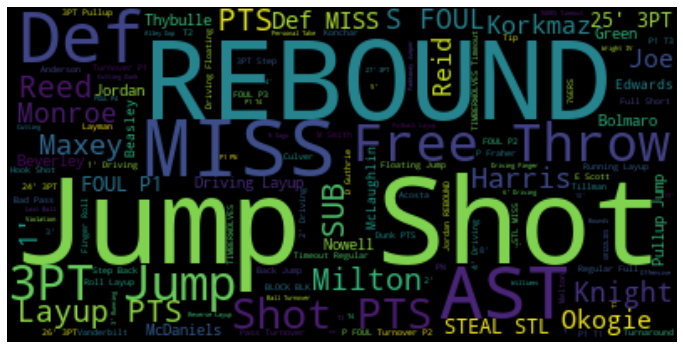

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud2 = WordCloud().generate(' '.join(frame['HOMEDESCRIPTION'].fillna('')))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# This was crashing until I made a new Conda env, re-installing my libraries
# Run the LinReg
lr = LinearRegression()
lr.fit(test_df.drop(cols,axis=1),test_df['HOME_VS_AWAY_PER_POSSESSION'])
linreg_results = pd.DataFrame({'coef':lr.coef_, 'player':test_df.drop(cols,axis=1).columns}).sort_values(by = 'coef', ascending = False)
linreg_results['player']=linreg_results['player'].astype(int)
linreg_results_player = linreg_results.merge(player_minutes,how='inner',left_on='player',right_on='PLAYER_ID')
linreg_results_player

In [ ]:
linreg_results_player[linreg_results_player['MIN']>=500].head(50)

In [ ]:
results = test_df.corr().reset_index()
results

In [ ]:
more_results = results[~results['index'].isin(cols)][['index','HOME_VS_AWAY_PER_POSSESSION']]
more_results['index']=more_results['index'].astype(int)
player_results = more_results.merge(players,how='inner',left_on='index',right_on='PLAYER_ID')
player_results.sort_values(by='HOME_VS_AWAY_PER_POSSESSION',ascending=False,inplace=True)
player_results.head(50)

In [ ]:
player_results.tail(50)

In [ ]:
player_results[player_results['TEAM_ABBREVIATION']=='MEM']

In [57]:
# # Get a list of games
# extract_data('https://stats.nba.com/stats/leaguegamelog?Counter=1000&DateFrom=&DateTo=&Direction=DESC&LeagueID=00&PlayerOrTeam=P&Season=2021-22&SeasonType=Playoffs&Sorter=DATE').sort_values(by='MIN')